<a href="https://colab.research.google.com/github/yerzhanimanmalik/skoltech-courses/blob/master/NeuroML_Yerzhan_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW1 - baseline

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/adasegroup/NEUROML2020/blob/seminar1/seminar1/hw1-baseline.ipynb)

In this notebook we handle the homework data in order to predict motion over rest using EEG

## Load data

In [50]:
# For Colab only
!pip install mne
!wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/train.csv
!wget https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/test.csv

--2020-09-25 04:09:34--  https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5381138 (5.1M) [text/plain]
Saving to: ‘train.csv.1’

train.csv.1         100%[===================>]   5.13M  18.7MB/s    in 0.3s    

2020-09-25 04:09:36 (18.7 MB/s) - ‘train.csv.1’ saved [5381138/5381138]

--2020-09-25 04:09:36--  https://raw.githubusercontent.com/adasegroup/NEUROML2020/seminar1/seminar1/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3567877 (3.4M) [text/pl

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mne.time_frequency import psd_array_multitaper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

%matplotlib inline

In [52]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
len(df_train['epoch'].unique())

180

In [53]:
df_train.head()

,time,condition,epoch,C3,Cz,C4,Fp1,Fp2,F7,F3,Fz,F4,F8,T7,T8,P7,P3,Pz,P4,P8,O1,O2
0,0,1,0,-5.885714,-2.533107,9.866895,7.962973,5.694433,23.638605,27.899784,13.487987,6.664778,23.588723,12.178548,0.685809,-4.887397,-10.646985,-14.735646,-8.729323,-0.562578,-17.055458,-3.616732
1,1,1,0,-7.999715,-16.916729,-11.924855,17.955477,8.526994,56.635981,28.508435,6.782457,-0.899474,1.045533,14.656061,-4.119778,-4.632381,-17.980657,-23.456960,-12.960684,-9.639784,-20.233549,-1.229811
2,2,1,0,-6.727283,-15.979567,-11.114195,17.183478,4.497028,43.914130,10.079754,-6.513665,-13.268111,-14.741630,14.793562,-6.624813,-3.402757,-10.269473,-18.736144,-3.579046,-0.045658,-14.089755,2.453398
3,3,1,0,6.819390,-0.204905,10.090124,20.265222,7.843006,36.250611,13.291199,-1.018772,-9.406679,-7.135541,21.723418,-2.276825,2.066859,4.325365,-2.803322,8.835114,13.878945,-5.772410,7.657873
4,4,1,0,13.129486,-5.817193,5.040633,19.462210,9.634234,42.311729,20.641012,3.262756,-3.990618,0.015602,19.703190,3.739076,2.714350,3.251047,-3.631448,3.212956,4.635574,-5.045448,5.086024


In [54]:
np.unique(df_train['condition'])

array([1, 2, 3])

In [55]:
ch_names = df_train.columns[3:]
epochs = df_train['epoch'].unique()
epochs

array([  0,   2,   6,   8,  11,  13,  15,  16,  17,  18,  19,  20,  21,
        22,  23,  24,  25,  26,  29,  30,  31,  32,  33,  34,  36,  37,
        38,  39,  42,  43,  44,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  58,  60,  61,  62,  64,  65,  66,  67,  68,  69,
        74,  77,  79,  80,  81,  86,  87,  88,  89,  90,  91,  93,  95,
        96,  97,  99, 101, 102, 105, 107, 109, 110, 111, 113, 115, 117,
       118, 126, 127, 128, 129, 131, 134, 135, 136, 137, 138, 139, 141,
       142, 143, 144, 145, 147, 151, 152, 154, 155, 156, 157, 158, 159,
       160, 162, 164, 166, 167, 169, 171, 172, 173, 174, 175, 176, 177,
       181, 182, 184, 185, 187, 192, 193, 194, 196, 197, 200, 201, 202,
       204, 205, 210, 212, 216, 217, 221, 222, 223, 225, 226, 227, 228,
       230, 231, 233, 234, 235, 237, 239, 240, 241, 244, 245, 246, 248,
       250, 253, 254, 255, 261, 262, 263, 265, 268, 269, 270, 276, 277,
       279, 281, 283, 285, 287, 290, 292, 293, 294, 297, 298])

In [56]:
def get_target(df):
    return df.drop_duplicates('epoch')[['epoch', 'condition']].reset_index(drop=True)

## Idea for feature engineering

condition == 1    Resting state

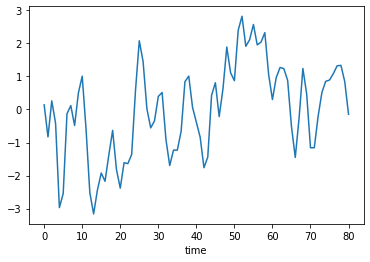

In [60]:
df_train[df_train['condition'] == 1].groupby('time')['F4'].mean().plot()

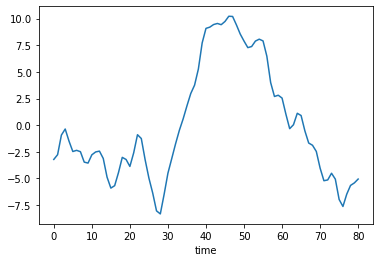

In [61]:
df_train[df_train['condition'] != 1].groupby('time')['F4'].mean().plot()

In [95]:
def calc_features(df):
    feats = []
    for epoch_idx, epoch_df in df.groupby('epoch'):

        epoch_df = epoch_df[ch_names]

        psds, freqs = psd_array_multitaper(epoch_df.T.values, 160, verbose=False)

        total_power = psds.sum(axis=1)

        idx_from = np.where(freqs > 13)[0][0]
        idx_to = np.where(freqs > 25)[0][0]
        b_pwr = psds[:,idx_from:idx_to].sum(axis=1) / total_power

        d = {}
        d['epoch'] = epoch_idx

        for ch in ch_names:
            s = epoch_df.iloc[40:][ch]
            val = (s > 5).sum()
            d[ch.lower() + '_p300'] = val

        feats.append(d)

    feats_df = pd.DataFrame(feats)
    
    return feats_df

## Common ML workflow

In [96]:
X = get_target(df_train)
print(calc_features(df_train))
X = X.merge(calc_features(df_train), on='epoch')
y = X['condition'].apply(lambda x: 0 if x == 1 else 1)
del X['epoch']
del X['condition']

     epoch  c3_p300  cz_p300  c4_p300  ...  p4_p300  p8_p300  o1_p300  o2_p300
0        0       10       20       21  ...       22       19       27       25
1        2       19       18       18  ...       17       18       18       17
2        6        7        9       12  ...       19       20       23       19
3        8        9       15       17  ...       17       22        8       10
4       11        7        8       12  ...       10       13       15       13
..     ...      ...      ...      ...  ...      ...      ...      ...      ...
175    292       12       15        9  ...       12       18       23       22
176    293       11        9        8  ...       15       14       15       16
177    294       15       14       15  ...       13       15       17       16
178    297       29       21       18  ...       24       23       31       28
179    298       14       13       23  ...       18        9       19       10

[180 rows x 20 columns]


In [97]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [98]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Logistic Regression

In [99]:
model = LogisticRegression(penalty='l2', solver = 'liblinear', C = 0.5)
model.fit(X_train_sc, y_train)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [100]:
y_pred_train = model.predict_proba(X_train_sc)[:, 1]
roc_auc_score(y_train, y_pred_train)

0.795200892857143

In [101]:
y_pred = model.predict_proba(X_test_sc)[:, 1]

In [102]:
roc_auc_score(y_test, y_pred)
print(len(y_test))

60


In [103]:
y_pred_train = model.predict_proba(X_train_sc)[:, 1]
roc_auc_score(y_train, y_pred_train)

0.795200892857143

### Random Forest

In [128]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    'n_estimators'      : [10, 15, 20, 30, 40, 50],
    'max_depth'         : [9, 11, 13, 15, 17],
    'criterion'         : ['gini']
}

In [129]:
n_iter = 20

clf = RandomizedSearchCV(RandomForestClassifier(), param_distributions=parameters,
                                   n_iter=n_iter, cv=5, iid=False,
                                  scoring = 'roc_auc')
clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [130]:
pars = pd.DataFrame(clf.cv_results_)
pars.sort_values(by=['rank_test_score']).head(n=8)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
12,0.067360,0.004040,0.005825,0.000122,50,17,gini,"{'n_estimators': 50, 'max_depth': 17, 'criteri...",0.854167,0.493007,0.786713,0.954545,0.580420,0.733770,0.171769,1
11,0.045640,0.000118,0.004907,0.000047,30,9,gini,"{'n_estimators': 30, 'max_depth': 9, 'criterio...",0.868056,0.520979,0.769231,0.933566,0.569930,0.732352,0.162063,2
7,0.024487,0.000153,0.003722,0.000042,15,15,gini,"{'n_estimators': 15, 'max_depth': 15, 'criteri...",0.770833,0.580420,0.776224,0.863636,0.643357,0.726894,0.101485,3
6,0.057739,0.002852,0.005622,0.000242,40,15,gini,"{'n_estimators': 40, 'max_depth': 15, 'criteri...",0.805556,0.513986,0.769231,0.905594,0.618881,0.722650,0.139155,4
13,0.027594,0.000438,0.003753,0.000077,20,9,gini,"{'n_estimators': 20, 'max_depth': 9, 'criterio...",0.743056,0.597902,0.699301,0.951049,0.615385,0.721338,0.126639,5
8,0.031382,0.000245,0.004095,0.000052,20,11,gini,"{'n_estimators': 20, 'max_depth': 11, 'criteri...",0.822917,0.531469,0.692308,0.891608,0.664336,0.720527,0.126055,6
0,0.045078,0.003190,0.005058,0.000909,30,17,gini,"{'n_estimators': 30, 'max_depth': 17, 'criteri...",0.850694,0.580420,0.671329,0.888112,0.601399,0.718391,0.127474,7
3,0.066696,0.001365,0.005820,0.000101,50,13,gini,"{'n_estimators': 50, 'max_depth': 13, 'criteri...",0.850694,0.538462,0.751748,0.849650,0.587413,0.715593,0.130642,8


In [131]:
clf.best_params_

{'criterion': 'gini', 'max_depth': 17, 'n_estimators': 50}

In [132]:
rf_model = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=17)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=17, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [133]:
y_pred_test_rf = rf_model.predict(X_test)
roc_auc_score(y_pred_test_rf, y_test)

0.6314285714285715

In [134]:
y_pred_train_rf

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0])

## Visualize t-SNE

In [74]:
X_embedded = TSNE(n_components=2).fit_transform(X)

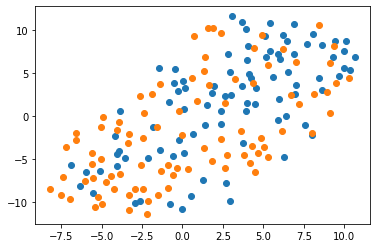

In [75]:
plt.scatter(X_embedded[np.where(y == 0), 0], X_embedded[np.where(y == 0), 1])
plt.scatter(X_embedded[np.where(y == 1), 0], X_embedded[np.where(y == 1), 1])

## Build submission

In [76]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

In [77]:
model.fit(X_sc, y)

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [78]:
X_test = calc_features(df_test)
submission = X_test[['epoch']].copy()
del X_test['epoch']
X_test_sc = scaler.transform(X_test)

In [79]:
y_pred = model.predict_proba(X_test_sc)[:, 1]

In [80]:
submission['Predicted'] = y_pred

In [81]:
submission['Id'] = submission['epoch']
del submission['epoch']

In [83]:
submission.to_csv('log_reg_submission.csv', index=False)